# Week 2 and 3: End-to-end Supervised Learning Project (Regression)

# Week 2: Data Exploration and Visualization

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥ 1.0

In [ ]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, )

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

"""
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
"""

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Get the Data

First of all let's import the data from the CSV file.

In [ ]:
filepath = os.path.abspath(os.path.join('..', 'datasets', 'kings_county_house_data.csv'))
print('File path: {}'.format(filepath))
housing = pd.read_csv(filepath, dtype={'zipcode': str})

We can get an overall idea of the fields available using the `DataFrame.info()` and `DataFrame.describe()` methods.

In [ ]:
housing.info()

In [ ]:
housing.describe()

## 2. Create a Training and Test Set

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside. We will use a function from `scikit-learn` which splits a dataset into training and test set.

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
train_set.shape, test_set.shape

In this way we would just be doing a simple randomized sampling. But this might not be a representative sampling of the whole dataset, if we do not preserve the proportions (or percentages) of significant input features. Let's hypothesize that we learned from expert the `sqft_living` field is an important predictor for the house price. 

In [ ]:
housing.sqft_living.hist(bins=100, figsize=(14,10))
plt.show()

In [ ]:
housing["sqft_living_cat"] = pd.cut(housing.sqft_living, 
                                    bins=[0., 1000., 2000., 3000., 4000., np.inf],
                                    labels=[1, 2, 3, 4, 5]
                                   )
housing['sqft_living_cat'].hist()
plt.show()

In [ ]:
housing['sqft_living_cat'].value_counts() / len(housing)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(housing, housing.sqft_living_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_train_set.shape, strat_test_set.shape

In [ ]:
strat_train_set.sqft_living_cat.value_counts() / len(strat_train_set)

In [ ]:
strat_test_set.sqft_living_cat.value_counts() / len(strat_test_set)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("sqft_living_cat", axis=1, inplace=True)

## 3. Discover and Visualize the Data to Gain Insights

### 3.1 Outlier Detection (optional)

In [ ]:
p = strat_train_set[
    ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
     'lat', 'long', 'sqft_living15', 'sqft_lot15']
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

In [ ]:
strat_train_set[['price']].boxplot(figsize=(15,10))

Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

Wikipedia Definition:
_The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, $IQR = Q_3 − Q_1$.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers._

If a data point is below $Q_1 - 1.5\times IQR$ or above $Q_3 + 1.5\times IQR$ then it's an outlier.

<b>Exercise 1:</b> Compute for me the count of outliers in our training set with respect to the `price` feature. (Hint: check the `DataFrame.quantile()` method and find a way to count the occurrences of values in a column of a DataFrame.) Additionally, write the code to remove those outliers. 

In [ ]:
## Write you solution here. Add as many cells as you see fit


Are the outliers legitimate or should we remove them?

### 3.2 Visualize geographical data

In [ ]:
strat_train_set.plot(
    kind="scatter", x="long", y="lat", figsize=(15,10)
)
plt.show()

In [ ]:
strat_train_set.plot(kind="scatter", x="long", y="lat", alpha=0.1, figsize=(15,10))
plt.show()

In [ ]:
strat_train_set.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=strat_train_set["sqft_living"]/100, label="sqft_living",
    c="price", cmap=plt.get_cmap('jet'), colorbar=True
)
plt.legend()
plt.show()

Using the same colormap (i.e. jet), we can try to improve the visualization above, setting an upper value that is reasonable, (i.e less or equal to QR3 + 1.5 IQR such as 1,000,000 $), and not the highest value in the range.

We can create a custom discrete colorbar by using `matplotlib.colors.BoundaryNorm` as normalizer for your scatterplot. See the norm argument in `matplotlib.pyplot.scatter()`: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html


In [ ]:
cmap = plt.cm.jet  # define the colormap
bounds = np.linspace(0, 1e6, 11) # define 11 evenly space

# The matplotlib.colors.BoundaryNorm class is used to create a colormap based on discrete numeric intervals.
norm = mpl.colors.BoundaryNorm(
    bounds, # Monotonically increasing sequence of boundaries
    cmap.N # Number of colors in the colormap to be used
)

plt.figure(figsize=(20, 13))
plt.scatter(
    x=strat_train_set["long"],
    y=strat_train_set["lat"],
    alpha=0.1,
    s=strat_train_set["sqft_living"]/100, # size of the dot
    label=strat_train_set["sqft_living"],
    c=strat_train_set["price"], # colour of the dot
    cmap=cmap, # colour map 
    norm=norm # used to scale the color data, c, in the range 0 to 1, in order to map into the colormap cmap
)
plt.colorbar(label="Price", orientation="vertical")
plt.show()

In [ ]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.linspace(0, 1e6, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
plt.figure(figsize=(20, 13))
plt.scatter(
    x=strat_train_set["long"], y=strat_train_set["lat"],
    alpha=0.1,
    s=strat_train_set["sqft_living"]/100, label=strat_train_set["sqft_living"],
    c=strat_train_set["price"], cmap=cmap, norm=norm
)
plt.colorbar(label="Price", orientation="vertical")
plt.show()

<b>Exercise 2:</b> explore on your own other ways to improve the graph above. You could look for ways to overlap it on top of the county map, or you could see if you can encode information differently

In [ ]:
### Write your solution here


### 3.2 Looking for correlations

The dataset is not that big, and we can compute the standard correlation coefficient (Pearson’s r coefficient) between every two features using the `DataFrame.corr()` method:

In [ ]:
corr_matrix = strat_train_set.corr()
corr_matrix["price"].sort_values(ascending=False)

N.B. The correlation coefficient only measures linear correlations, and it may completely miss nonlinear correlation factors. 

Another way to check for correlation visually is to use the `scatter_matrix()` utility function offered by Pandas, which leverages `matplotlib`, or seaborn's `pairplot()` function.

In [ ]:
attributes = ["price", "sqft_living", "grade",
              "sqft_above", "sqft_living15", "bathrooms"]
pd.plotting.scatter_matrix(
    strat_train_set[attributes], figsize=(15, 10)
)
plt.show()

In [ ]:
import seaborn as sns
ax = sns.pairplot(strat_train_set[attributes])

We can then start using boxplots or violinplots to further investigate targeted correlations, such as 'grade' vs 'price' or 'floors' vs 'price'.

<b>Exercise 3:</b> write a function that takes a categorical or ordinal feature as a first argument, the size of a figure as a second argument and plots, using seaborn, a set of boxplots of the price distribution for each category in the input categorical feature.

In [ ]:
## Write you solution here.
# Populate the function body. I've written the function interface (i.e. its API) for you
def print_boxplot(feature, figsize=(14, 6)):
    """
    write your function here, removing the "pass" statement
    """
    pass

In [ ]:
## Try your function to plot 'grade' vs 'price'.
## If you have implemented it correctly it will plot out the boxplots
print_boxplot('grade')

In [ ]:
## Try your function to plot 'floors' vs 'price'.
## If you have implemented it correctly it will plot out the boxplots
print_boxplot('floors', figsize=(12, 12))

In [ ]:
## Try your function to plot 'bathrooms' vs 'price'.
## If you have implemented it correctly it will plot out the boxplots
print_boxplot('bathrooms', figsize=(20, 12))

## Week 3: Data Pre-processing and Regression Algorithms

## 4. Preparing the Data for Machine Learning Algorithms

### 4.1 Data Cleaning

In [ ]:
housing = strat_train_set.drop("price", axis=1) # drop labels for training set
housing_labels = strat_train_set["price"].copy()

In [ ]:
housing.head()

In [ ]:
housing_labels.head()

##### 4.1.1 Missing values and imputation

We can use `pd.DataFrame.isna()` or `pd.DataFrame.isnull()` to look for null or missing values in any of our variables/features.

NOTE: axis=1 performs the operation along the columns

In [ ]:
## Look for rows with incomplete values
incomplete_rows = housing[housing.isna().any(axis=1)]
incomplete_rows

In statistics, imputation is the process of replacing missing data with substituted values.
In scikit-learn we can use the `SimpleImputer` calss to perform imputation on missing  values. Generally we wil want to replace missing numeric (quantitative) values with the median value of that feature. For categorical features we may want to either use a "missing"/"unknown" category, use the mode, or drop the samples with missing values.

As there is no missing values in our dataset we would not really need to do this.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.sort_values(by='bathrooms', ascending=True)

In [ ]:
housing_tr.loc[[14423, 1149, 6994]]

We might want to look for weird values as well...as it can be seen from the boxplotof bathrooms vs price some houses seem to have no bathroom. This is most likely an error and we may wont to replace those values with the median values for for bathrooms as well.

In [ ]:
housing_tr.loc[housing['bathrooms'] == 0, 'bathrooms'] = np.nan
housing_tr.bathrooms.isna().value_counts()

In [ ]:
housing_tr.bathrooms.fillna(housing_tr.bathrooms.median(), inplace=True)

In [ ]:
housing_tr.loc[[14423, 1149, 6994]]

### 4.2 Transform Rows

It is always a good practice to write functions (or classes) to perform data transformations, so that these operations can later be performed in a reliable and reproducible way.

Below, we have a method that replaces zeroes with the median values for bathrooms, and splits the date the house was sold into `month_bought` and `yr_bought`, then computes the `age` (in years) of teh house when it was sold and introduces a boolean flag (`renovated_flag`) that states whether the house was renovated or not before being sold. It then removes features deemed not relevant (such as `id`, `date`, `yr_built`, `yr_bought`, `month_bought`, `yr_renovated`).

In [ ]:
housing['date']

In [ ]:
def transform_housing_rows(housing_df):
    """
    cleans up the data 
    """
    res = housing_df.copy()
    # houses with 0 bathrooms are a mistake, set them as null values
    res.loc[housing_df['bathrooms'] == 0, 'bathrooms'] = np.nan
    # use median imputing for missing values in bathrooms
    res.bathrooms.fillna(res.bathrooms.median(), inplace=True)
    # split the acquisition date in year and month and compute the age of the house when bought
    if 'date' in res.columns.values:
        res['yr_bought'] = res['date'].apply(lambda d: int(d[:4]))
        res['month_bought'] = res['date'].apply(lambda d: int(d[4:6]))
        res['age'] = res['yr_bought'] - housing_df['yr_built']
    # create a boolean flag to see whether the house was renovated or not
    res['renovated_flag'] = res['yr_renovated'].apply(lambda el: 0 if el == 0.0  else 1)
    # drop not relevant columns
    return housing_df.drop(
        columns=['id', 'date', 'yr_built', 'yr_bought', 'month_bought', 'yr_renovated'],
        errors='ignore'
    )
    
housing_proc = transform_housing_rows(housing)
housing_proc.head()

### 4.2 Handling Text and Categorical Attributes

In general we can consider three types of text features: categorical, ordinal, and unstructured.
Unstructured text is more the subject of Natural Language Processing, hence we will not consider its processing/encoding at this stage (and we have no unstructured data). Ordinal data are text categories that imply and intrinsic order such as the set ("BAD", "AVERAGE", "GOOD", "VERY GOOD", "EXCELLENT"). These are generally encodes as integers ("BAD" => 0, "AVERAGE" => 1, "GOOD" => 2, "VERY GOOD" => 3, "EXCELLENT" => 4). These transformations can be handed with custom functions as above.

To handle Categorical Attributes that are not ordinal, a common solution is to create one binary attribute per category. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy attributes*. Scikit-Learn provides a `sklearn.preprocessing.OneHotEncoder` class to convert categorical values into one-hot vectors.

In our case we have the "zipcode" attribute that can be considered as categorical. Each "zipcode" category should become a mutually exclusive dummy attribute

<b>Exercise 4:</b> Use the `OneHotEncoder` class to encode each ZIP code as a separate category. Check the documentation for appropriate use of the `OneHotEncoder` transformer. What kind of output do you get? 

In [ ]:
## Write your solution here
from sklearn.preprocessing import OneHotEncoder

### 4.3 Custom Transformers (see if we should do this one)

You can define you own transformers creating a class that inherits both from `BaseEstimator` (so that it inherits the `.fit()` method) and the mixin class `TransformerMixin` (so that it acquires the `.tranform()` method)

Here below you can see a transformer that set two new features: `renovated_flag` and `age`.

Transformers can take DataFrames as inputs but always output NumPy arrays, so for some transformations where you find more convenient to work on DataFrame you might prefer just to write you own functions that return a modified DataFrame as we did with `transform_housing_rows()`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

yr_built_ix = housing.columns.values.tolist().index('yr_built') 
yr_renovated_ix = housing.columns.values.tolist().index('yr_renovated')
print(yr_built_ix, yr_renovated_ix)

class ManipulatedAttributesAdder(BaseEstimator, TransformerMixin):
    
    CURRENT_YEAR = 2017
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        age = self.CURRENT_YEAR - X[:, yr_built_ix]
        renovated_flag = np.apply_along_axis(lambda r: 0 if r[yr_renovated_ix] == 0 else 1, 1, X)
        return np.concatenate((X, age[:, np.newaxis], renovated_flag[:, np.newaxis]), axis=1)

attr_adder = ManipulatedAttributesAdder()
housing_extra_attribs = pd.DataFrame(
    attr_adder.transform(housing_num.values),
    columns=[*housing_num.columns.values.tolist(), 'age', 'is_renovated'],
    index=housing_num.index
)
housing_extra_attribs.head(10)

An alternative way to perform this transformation:

### 4.4 Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. In the great majority of case, Machine Learning algorithms will not perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale:
* min-max scaling:  rescaling the range of features to scale the range in [0, 1] or [−1, 1] (using scikit-learn `MinMaxScaler`)
* standardization: scales the data to have zero mean and variance = 1 (using scikit-learn `StandardScaler`).

### 4.5 Transformation Pipelines

We are goin to use a `StandardScaler` directly after our `ManipulatedAttributesAdder` class using a Tranformation Pipeline

In [ ]:
housing_num.describe()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

housing_num_tr = transform_housing_rows(housing_num)
housing_num_prepared = num_pipeline.fit_transform(housing_num_tr)
housing_num_prepared.shape

In [ ]:
housing_num_prepared.min(axis=1), housing_num_prepared.max(axis=1)

Until now, we have handled the categorical columns and the numerical columns separately. It would be more convenient if we had just one transformer capable to handle all columns, applying the appropriate transformations to each column. Solution: we can use scikit-learn `ColumnTransformer`!

<b>Exercise 5:</b> Use the `sklearn.compose.ColumnTransformer` class to create a pipeline that processes separately the numeric/quantitative attributes (using the `num_pipeline` that we have defined above) and the Categorical Atrribute `zipcode` using a one-hot-encoding without scaling. The binary attributes should remain unmodified

Hint: check the `ColumnTransformer` API: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [ ]:
## Write your solution here:

from sklearn.compose import ColumnTransformer

housing_tr = transform_housing_rows(housing)



cat_attribs = ["zipcode"]
binary_attributes = ["renovated_flag", "waterfront", "view"] 
num_attribs = [
    el for el in list(
        housing_tr.select_dtypes(include=[np.number])
    ) if el not in binary_attributes
]
print(num_attribs)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories='auto'), cat_attribs),
        # ("bin", None, binary_attributes)
], remainder='passthrough')


housing_prepared = full_pipeline.fit_transform(housing_tr)

`OneHotEncoder` returns a sparse matrix, while `num_pipeline` returns a dense matrix. `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold. In this example, it returns a sparse matrix. 

And now we are done! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

In [ ]:
housing_prepared

In [ ]:
type(housing_prepared)

## Save all the pre-processed data (if needed, skipped in the class demo)

We will use `scipy.sparse.save_npz()` to save the sparse matrix, `np.save()` to save the NumPy arrays as `.npy` binary files, and `pickle` from the Python standard library to save our `full_pipeline`

In [ ]:
"""
import pickle
from scipy.sparse import save_npz

X_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_house_data_prepared.npz'))
y_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_prediction.npy'))
train_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_train_set.csv'))
test_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_test_set.csv'))
pipeline_filepath = os.path.abspath(os.path.join('..', 'dumps', 'full_preprocessing_pipeline'))

# create the "dumps" directory if it does not exist
os.makedirs(os.path.abspath(os.path.join('..', 'dumps')), exist_ok=True)

with open(pipeline_filepath, 'wb') as file_handle:
    pickle.dump(full_pipeline, file_handle)
    
print(type(strat_train_set), type(strat_test_set))

save_npz(X_filepath, housing_prepared)
np.save(y_filepath, housing_labels)
strat_train_set.to_csv(train_set_filepath)
strat_test_set.to_csv(test_set_filepath)
# np.save(train_set_filepath, strat_train_set)
# np.save(test_set_filepath, strat_test_set)
"""

In [ ]:
"""
some_data = strat_train_set.iloc[:10]
some_labels = strat_test_set.iloc[:10]
preprocessed_some_data = full_pipeline.transform(some_data)
"""

## 5. Select and train a model - Regression


We will start by looking at the Linear Regression model, the simplest Regression model there is. There are two different ways to train it:

* Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

* Using an iterative optimization approach called Gradient Descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent: Batch GD, Mini-batch GD, and Stochastic GD. This will be used again later on, when we will be seeing Neural Networks

In [ ]:
# For now we will only use the numerical fields and discard the categorical field "zipcode"
housing_num

In [ ]:
housing_labels

In [ ]:
# transform_housing_rows cleans-up and feature-engineers our dataset
housing_num_tr = transform_housing_rows(housing_num)

# num_pipeline does (1) imputing: replaces missing values with the median value for the feature
# and (2) standardizes features by removing the mean and scaling to unit variance.
housing_prepared = num_pipeline.fit_transform(housing_num_tr)
housing_prepared.shape

### 5.1 Linear Regression - Closed form solution: Normal Equation 

We will use the `LinearRegression` class from `scikit-learn`

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
len(lin_reg.coef_)

Let’s try it out on a few instances from the training set:

In [ ]:
some_data = housing_num.iloc[:10]
some_labels = housing_labels.iloc[:10]
preprocessed_some_data = num_pipeline.transform(
    transform_housing_rows(some_data)
)

In [ ]:
print("Predictions:", lin_reg.predict(preprocessed_some_data))
print("Labels:", list(some_labels))

It mostly works, although the predictions are not exactly accurate. Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function and computing its square root:

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_mse

In [ ]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model

### 5.2 Linear Regression -  Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The concept behind Gradient Descent is to modify parameters iteratively to minimize a cost function.

The MSE cost function for a Linear Regression model is a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.

#### 5.2.1 Batch Gradient Descent

No example on this.

#### 5.2.2 Stochastic Gradient Descent

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class. It defaults to optimizing the squared error cost function. 

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    loss="squared_error", # default cost function (MSE)
    max_iter=1000,   # maximum number of passes over the training data (aka epochs)
    penalty=None, # no regularisation
    eta0=0.01,  # initial learning rate
    tol=1e-3,   # stopping criterion tolerance. stop searching for a minimum 
                # (or maximum) once some tolerance is achieved, i.e. 
                # once you're close enough.
)
sgd_reg.fit(housing_prepared, housing_labels)
print('SGD Regressor intercept: {}'.format(sgd_reg.intercept_))
print('SGD Regressor coefficient: {}'.format(sgd_reg.coef_))

In [ ]:
housing_predictions = sgd_reg.predict(housing_prepared)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(lin_mse)
sgd_rmse

### Learning curves

Learning curves are a way to check whether your algorithm is learning properly. They are plots of the model's performance on the train and validation set as a function of the number of training iterations (or the size of the training set).

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns

@ignore_warnings(category=ConvergenceWarning)
def plot_learning_curves(model, X, y, max_training_samples=None):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2
    )
    train_errors, val_errors = [], []
    # for training set size from 1 to max_training_samples
    for m in range(1, min(len(X_train), max_training_samples)):
        # train a new model
        model.fit(X_train[:m], y_train[:m])
        # make predictions on the training and validation set
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        # compute the MSE on the training and validation set
        train_errors.append(
            mean_squared_error(y_train[:m], y_train_predict)
        )
        val_errors.append(
            mean_squared_error(y_val, y_val_predict)
        )
    fig, ax = plt.subplots(figsize=(16,10))
    # plot our performance metric (i.e. the RMSE)
    sns.lineplot(data=np.sqrt(train_errors), linewidth=2, label="train", ax=ax)
    sns.lineplot(data=np.sqrt(val_errors), linewidth=2, label="val", ax=ax)

In [ ]:
%%time
plot_learning_curves(
    sgd_reg, housing_prepared, housing_labels, max_training_samples=5000
)

Training and validation set actually have the same RMSE for $n_{samples} > 100$ but we can see that the RMSE flattens and does not keep decreasing. This means that the model is underfitting the training data.

If the model were overfitting the data you would notice a gap between the training and the validation curve (i.e. the validation error would be consistently greater than the training error)

<b>Exercise 6:</b> Initialize and train a `SGDRegressor` named `sgd_reg` with initial learning rate of $0.005$, `penalty` set to `None`, training for a maximum of 500 epochs over all the dataset. Then, pass the model and the input data and the output labels to the `plot_learning_curves()` function, setting its `max_training_samples` argument to $5000$. What is it plotting?

In [ ]:
## Write your solution here:


### 5.3 Polynomial Regression

What if your data is more complex than a straight line (or an (N-1)-dimensional plane in an N-dimensional space)? Surprisingly, you can use a linear model to fit nonlinear data. This can be done with Polynomial Regression.

Polynomial regression relies on polynomial features, which can get features’ high-order and interaction terms. 

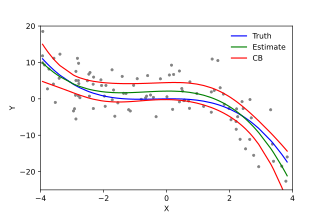

For instance if you have the features $X$ $Y$, polynomial features up to degree 2 will be $1$, $X$, $Y$, $X^2$, $XY$ $Y^2$.

Polynomial features up to degree 3 will be $1$, $X$, $Y$, $X^2$, $XY$ $Y^2$, $X^3$, $X^2Y$, $XY^2$, $Y^3$.



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
housing_poly = poly_features.fit_transform(housing_prepared)

In [ ]:
housing_prepared[0].shape

In [ ]:
housing_poly.shape

In [ ]:
230/20

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_poly, housing_labels)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
housing_predictions = lin_reg.predict(
    poly_features.transform(housing_prepared)
)
poly_mse = mean_squared_error(
    housing_labels, housing_predictions
)
poly_rmse = np.sqrt(poly_mse)
poly_rmse

We could see how the RMSE is with respect to the min-max range of prices ("labels") in our dataset.

In [ ]:
print('Lower housing price {}'.format(housing_labels.min()))
print('Higher housing price {}'.format(housing_labels.max()))
poly_rmse / (housing_labels.max() - housing_labels.min())

We could see how the RMSE is with respect to the min-max range of prices ("labels") in our dataset.

In [ ]:
print('Q1 = {}'.format(housing_labels.quantile(0.25)))
print('Q3 = {}'.format(housing_labels.quantile(0.75)))
poly_rmse / (housing_labels.quantile(0.75) - housing_labels.quantile(0.25))

In [ ]:
some_data = housing_num.iloc[:10]
some_labels = housing_labels.iloc[:10]
preprocessed_some_data = num_pipeline.transform(
    transform_housing_rows(some_data)
)
print("Predictions:", lin_reg.predict(
    poly_features.transform(preprocessed_some_data)
))
print("Labels:", list(some_labels))

Adding many polynomial features can increase the complexity of your model, which can cause overfitting.

To solve overfitting you will have to rely on regularization techniques, such as Ridge or Lasso Regularization (see below)

### 5.3.1 Using Cross Validation

Let's try and use the function `sklearn.model_selection.cross_val_score()` to evaluate our Polynomial Regression model on the training set using a 10-fold cross-validation with RMSE as a score. Print out the mean value and the standard deviation of the RMSE across the 10 validation iterations

In [ ]:
import time
from sklearn.model_selection import cross_val_score
start = time.time()
scores = cross_val_score(
    lin_reg, # model we want to train
    housing_poly, # features
    housing_labels, # labels
    scoring='neg_mean_squared_error', # -MSE
    cv=10
)

In [ ]:
scores

In [ ]:
poly_rmse_scores = np.sqrt(-scores)

In [ ]:
poly_rmse_scores.mean()

In [ ]:
poly_rmse_scores.std()

In [ ]:
# You can also use this function to print out mean value and std of the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", "{0:.2f}".format(scores.mean()))
    print("Standard deviation:", "{0:.2f}".format(scores.std()))

In [ ]:
display_scores(poly_rmse_scores) 

If I want to try more scoring metrics at once while performing cross-validation, and I want to get more information than just the scores themselves I can use `sklearn.model_selection.cross_validate()`.

In [ ]:
from sklearn.model_selection import cross_validate, KFold
start = time.time()
n_splits = 10
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_res = cross_validate(
    lin_reg,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
end = time.time()
print("Duration: {} s".format(end - start))

In [ ]:
cv_res

In [ ]:
poly_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(poly_rmse_scores) 

<b>Exercise 7:</b> Use the function `sklearn.model_selection.cross_val_score()` to evaluate our Stochastic Gradienr Regressor model on the training set using a 5-fold cross-validation using the mean absolute error (MAE) as a score. Print out the mean value and the standard deviation of the mean absolute error across the 5 validation iterations

In [ ]:
# Write your solution here


### 5.5 Ridge Regression

Ridge Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Ridge is equal to $ \alpha \sum_{i=1}^{N}{\theta_i^2} $. This means that it forces the learning algorithm to fit not only the data but also keep the model weights as small as possible. An important thing to note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance.

Ridge regression is a type of $\ell_2$ regularisation, because the regularisation term is equal to half the square of the $\ell_2$ norm of the weight vector.

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=100000, solver="cholesky")
cv_res = cross_validate(
    ridge_reg,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

In [ ]:
ridge_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(ridge_rmse_scores) 

### 5.6  Lasso Regression [skip]

Lasso Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Lasso is equal to $ \alpha \sum_{i=1}^{N}{\mid \theta_i \mid} $.


Lasso regression is a type of $\ell_1$ regularisation, because the regularisation term is equal to the $\ell_1$ norm of the weight vector.

### 5.7 Elastic Net [skip]

ElasticNet combines $\ell_1$ and $\ell_2$ regularisation.

In [ ]:
from sklearn.linear_model import ElasticNet
el_net = ElasticNet(alpha=100000, l1_ratio=0.01, max_iter=10000)
cv_res = cross_validate(
    el_net,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

In [ ]:
elnet_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(elnet_rmse_scores) 

### 5.8 Decision Trees 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()
cv_res = cross_validate(
    dtree,
    housing_num,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

In [ ]:
dtree_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(dtree_rmse_scores) 

In [ ]:
dtree_5 = DecisionTreeRegressor(max_depth=2)
most_important_feats =['sqft_living', 'grade', 'sqft_living15']
dtree_5.fit(housing_num[most_important_feats], housing_labels)

In [ ]:
from sklearn.tree import export_graphviz
os.makedirs(os.path.abspath(os.path.join("..", "output")), exist_ok=True)
export_graphviz(
    dtree_5,
    out_file=os.path.abspath(os.path.join("..", "output", "kc-dtree.dot")),
    feature_names=most_important_feats,
    # class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [ ]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(18,12))
res = plot_tree(
    dtree_5, 
    feature_names=most_important_feats, 
    rounded=True, 
    filled=True, 
    ax=ax,
    fontsize=18
)

### 5.8 Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_regr = RandomForestRegressor(n_estimators=10) # new default numnber of estimators is 100 since 0.22
start = time.time()
cv_res = cross_validate(
    forest_regr,
    housing_num,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
end = time.time()
print("Duration: {} s".format(end - start))
cv_res

In [ ]:
forest_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(forest_rmse_scores)

## 6. Fine-tuning of your model

### 6.1 Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30], 
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False], 
        'n_estimators': [3, 10], 
        'max_features': [2, 3, 4]
    },
]

forest_regr = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_regr, param_grid, cv=5,
    scoring='neg_mean_squared_error', return_train_score=True
)

In [ ]:
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(
    cv_res['mean_test_score'], 
    cv_res['params']
):
    print(np.sqrt(-mean_score), params)

### 6.2 Randomized Search

From https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. `RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

* A budget can be chosen independent of the number of parameters and possible values.
* Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`.

### 6.3 Ensemble Methods

A possible way to fine tune your model is just to combine the models that perform best. You can get a good ensemble estimator out of a bunch of sloppy estimators. Random Forests are just an ensemble of Decision Trees trained on a random subset of the training set. Check the `sklearn.ensemble` module for more Ensemble Methods.

## 7. Evaluate Your System on the Test Set

After trying various your models and hyperparameter combinations you will eventually have an algorithm that performs sufficiently well. At this point the time comes to evaluate the final model on the test set. 

<b>Exercise 8:</b> Evaluate your best model on the test set we held out at the beginning of our analysis pipeline. What performance do you get? Is that what you expected?

## 8. Deploy, Monitor, and Maintain Your System

At this stage you could think of wrapping the chosen model within a dedicated web service that your web application can access through a Web API. But this is the subject for another course!!

### This is the end of the demo for Week 2!!
See you next week